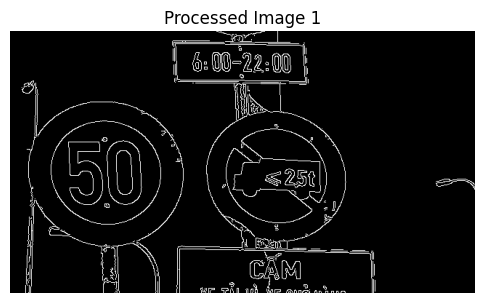

In [1]:
import cv2
import os
import matplotlib.pyplot as plt  # Thêm matplotlib để hiển thị ảnh
import numpy as np

# Ví dụ sử dụng
image_folder = r'C:\Users\ADMIN\OneDrive - Hanoi University of Science and Technology\Desktop\New folder'
image_list = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]



def apply_canny_to_images(image_paths: list, low_threshold=50, high_threshold=150) -> list:
    processed_images = []
    
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Không thể đọc được ảnh {image_path}")
            continue
        
        # Chuyển ảnh sang dạng grayscale (ảnh xám)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Áp dụng Canny edge detection
        edges = cv2.Canny(gray_img, low_threshold, high_threshold)
        
        # Chuyển ảnh edges sang 3 kênh để lưu ảnh và hiển thị dễ dàng hơn
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        
        # Thêm ảnh đã xử lý vào danh sách
        processed_images.append(edges_colored)
    
    return processed_images

canny_images = apply_canny_to_images(image_list, low_threshold=50, high_threshold=150)
'''
# Xem kết quả
for i, img in enumerate(processed_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Chuyển đổi từ BGR sang RGB để hiển thị đúng màu
    plt.title(f"Processed Image {i+1}")
    plt.axis('off')  # Tắt trục tọa độ
    plt.show()
    '''
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(canny_images[0], cv2.COLOR_BGR2RGB))  # Hiển thị ảnh đầu tiên
plt.title("Processed Image 1")
plt.axis('off')  # Tắt trục tọa độ
plt.show()

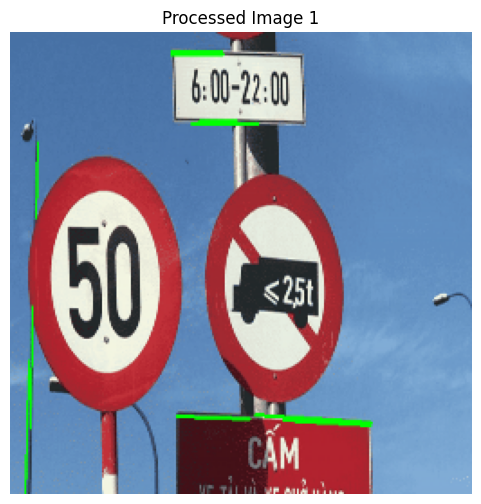

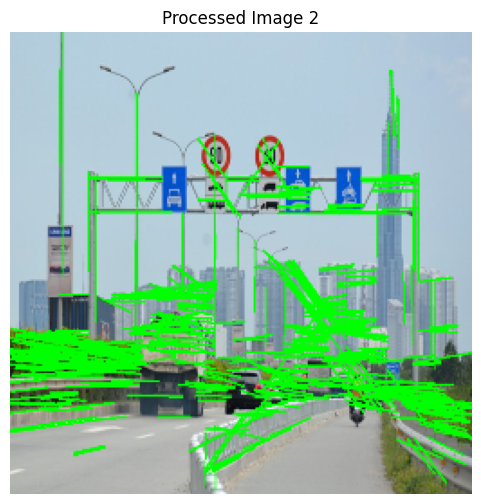

In [2]:
def preprocess_and_hough_transform(image_paths: list) -> list:
    processed_images = []
    for image_path in image_paths:
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            print(f"Không thể đọc được ảnh {image_path}")
            continue

        # Chuyển ảnh sang dạng grayscale (ảnh xám)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Áp dụng bộ lọc Canny để phát hiện biên
        edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)

        # Áp dụng Hough Line Transform để phát hiện các đoạn thẳng
        lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

        # Vẽ các đoạn thẳng phát hiện được lên ảnh gốc
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Đoạn thẳng màu xanh lá

        # Thay đổi kích thước ảnh (ví dụ: 256x256)
        resized_image = cv2.resize(image, (256, 256))

        # Thêm ảnh đã xử lý vào danh sách
        processed_images.append(resized_image)

    return processed_images

# Xử lý danh sách ảnh
processed_image = preprocess_and_hough_transform(image_list)

# Xem kết quả
for i, img in enumerate(processed_image):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Chuyển đổi từ BGR sang RGB để hiển thị đúng màu
    plt.title(f"Processed Image {i+1}")
    plt.axis('off')  # Tắt trục tọa độ
    plt.show()

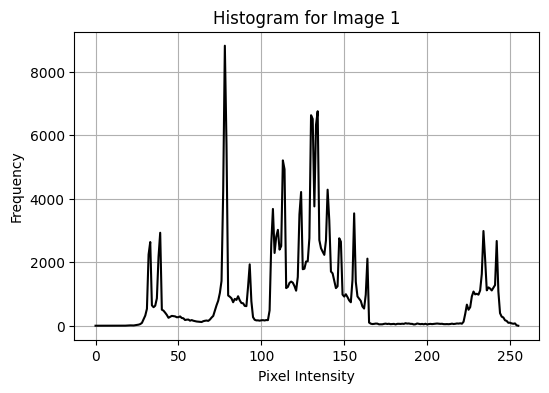

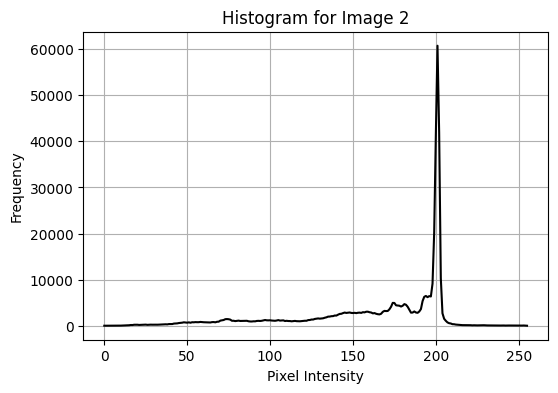

In [3]:
def compute_histogram_for_images(image_paths: list) -> list:
    histograms = []
    
    for image_path in image_paths:
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            print(f"Không thể đọc được ảnh {image_path}")
            continue

        # Chuyển ảnh sang dạng grayscale (ảnh xám)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Tính toán biểu đồ (histogram) cho ảnh xám
        histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

        # Thêm biểu đồ vào danh sách
        histograms.append(histogram)

    return histograms


# Tính toán danh sách histogram cho danh sách ảnh
histograms = compute_histogram_for_images(image_list)

# Hiển thị histogram của từng ảnh
for i, histogram in enumerate(histograms):
    plt.figure(figsize=(6, 4))
    plt.plot(histogram, color='black')
    plt.title(f"Histogram for Image {i+1}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

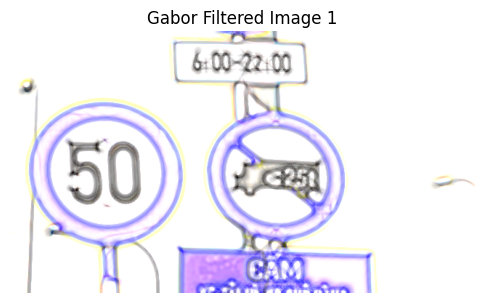

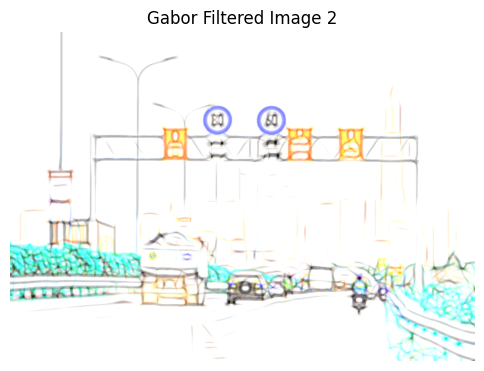

In [4]:
# Hàm scale ảnh về dải [0, 255]
def scale_to_0_255(img):
    min_val = np.min(img)
    max_val = np.max(img)
    new_img = (img - min_val) / (max_val - min_val)  # Chuyển về dải 0-1
    new_img *= 255  # Chuyển về dải 0-255
    return new_img.astype(np.uint8)

# Áp dụng bộ lọc Gabor cho 3 kênh của ảnh (BGR)
def apply_sliding_window_on_3_channels(img, kernel):
    layer_blue = cv2.filter2D(src=img[:,:,0], ddepth=-1, kernel=kernel)
    layer_green = cv2.filter2D(src=img[:,:,1], ddepth=-1, kernel=kernel)
    layer_red = cv2.filter2D(src=img[:,:,2], ddepth=-1, kernel=kernel)    
    
    new_img = np.zeros(list(layer_blue.shape) + [3], dtype=np.uint8)
    new_img[:,:,0], new_img[:,:,1], new_img[:,:,2] = layer_blue, layer_green, layer_red
    return new_img

# Tạo Gabor filter bank với 16 hướng
def generate_gabor_bank(num_kernels=16, ksize=(31, 31), sigma=4, lambd=10, gamma=0.5, psi=0):
    bank = []
    step = np.pi / num_kernels
    for idx in range(num_kernels):
        theta = idx * step
        kernel = cv2.getGaborKernel(ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)
        bank.append(kernel)
    return bank

# Áp dụng Gabor filter lên danh sách ảnh
def apply_gabor_filter_to_images(image_paths: list) -> list:
    processed_images = []
    gabor_bank = generate_gabor_bank(num_kernels=16)
    
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Không thể đọc được ảnh {image_path}")
            continue
        
        # Tạo ảnh tổng hợp chứa kết quả bộ lọc Gabor với 16 hướng
        avg_out = np.zeros_like(img, dtype=np.float32)
        
        for kernel in gabor_bank:
            res = apply_sliding_window_on_3_channels(img, kernel)
            avg_out += res
        
        # Tính trung bình kết quả và chuyển đổi về kiểu ảnh uint8
        avg_out /= len(gabor_bank)
        avg_out = avg_out.astype(np.uint8)
        
        # Thêm ảnh đã xử lý vào danh sách
        processed_images.append(avg_out)
    
    return processed_images

# Xử lý danh sách ảnh bằng Gabor filter
gabor_images = apply_gabor_filter_to_images(image_list)

# Hiển thị kết quả của từng ảnh
for i, img in enumerate(gabor_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')  # Hiển thị ảnh đã qua Gabor filter ở dạng ảnh xám
    plt.title(f"Gabor Filtered Image {i+1}")
    plt.axis('off')  # Tắt trục tọa độ
    plt.show()